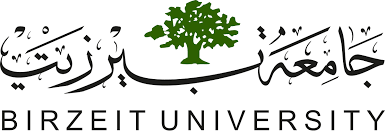

In [16]:
from IPython.display import Image
Image(filename='images.png') 

________________________________________________
Electrical and Computer Engineering Department

Machine Learning and Data Science ‐ ENCS5341

 Assignment #2
_________________________________________________________________________________________________
Prepared By: Tala Abahra   1201002, Sondos Shahin 1200166

Instructor: Dr. Yazan Abu Farha Date: Oct 30, 2024

Topic: Machine Learning Assignment: 1
https://github.com/sondosshahin/Machine-Learning-Project-Regression-Analysis-and-Model-Selection-


## 1 - Import Dataset YallaMotors

 The main objective of this dataset is to predict car prices,
making it ideal for developing regression models to understand the relationship between
various features (e.g., car make, model, year, mileage, engine size, etc.) and the target
variable (car price). 

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

missing_values = [" ", "NA", "N/A", "N A", "NaN"]
data = pd.read_csv("cars.csv", na_values=missing_values)
data.head()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,8.8,peugeot,ksa
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,4 Seater,suzuki,ksa
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,7.5,ford,ksa
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,5 Seater,honda,ksa


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6265 non-null   object
 6   seats            6205 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


In [25]:
data.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
count,6308,6308,6308,5684,6308,6265,6205,6308,6308
unique,2546,3395,129,10,330,168,81,82,7
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,5 Seater,mercedes-benz,uae
freq,10,437,1241,2856,162,1100,3471,560,1248


['fiat' 'peugeot' 'suzuki' 'ford' 'honda' 'renault' 'aston-martin' 'gac'
 'toyota' 'genesis' 'hyundai' 'lincoln' 'mg' 'chevrolet' 'mercedes-benz'
 'kia' 'volkswagen' 'land-rover' 'lotus' 'volvo' 'porsche' 'mini'
 'lamborghini' 'nissan' 'mclaren' 'changan' 'great-wall' 'bmw'
 'rolls-royce' 'audi' 'infiniti' 'ram' 'chrysler' 'gmc' 'borgward' 'jeep'
 'alfa-romeo' 'chery' 'skoda' 'lexus' 'jaguar' 'maxus' 'cadillac'
 'ferrari' 'mazda' 'mitsubishi' 'bestune' 'jetour' 'hongqi' 'maserati'
 'geely' 'byd' 'Foton' 'subaru' 'haval' 'isuzu' 'ssang-yong' 'dodge'
 'bentley' 'bugatti' 'opel' 'zotye' 'soueast ' 'dorcen' 'citroen'
 'brilliance' 'seat' 'proton' 'soueast' 'ds' 'jac' 'lada' 'kinglong'
 'baic' 'morgan' 'mahindra' 'tata' 'dfm' 'acura' 'abarth' 'zna' 'tesla']
['ksa' 'egypt' 'bahrain' 'qatar' 'oman' 'kuwait' 'uae']
['Fiat 500e 2021 La Prima' 'Peugeot Traveller 2021 L3 VIP'
 'Suzuki Jimny 2021 1.5L Automatic' ...
 'BMW M8 Convertible 2021 4.4T V8 Competition xDrive (625 Hp)'
 'BMW M8 Coupe 2021

NameError: name 'encoded_data' is not defined

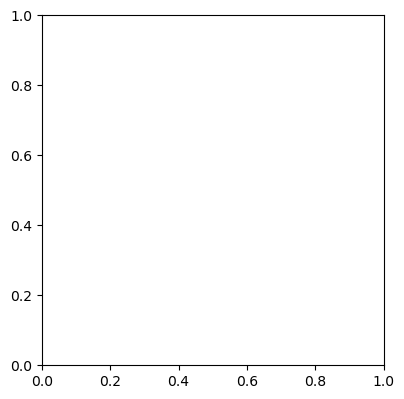

In [31]:
from sklearn.preprocessing import LabelEncoder
# Print unique values to check
print(data['brand'].unique())
print(data['country'].unique())
print(data['car name'].unique())

# categorical_features = ['car name', 'brand', 'country']
# encoded_data = data.copy()  # Create a copy to avoid overwriting the original dataset
# for column in categorical_features:
#     # Calculate frequency of each category
#     freq_encoding = encoded_data[column].value_counts() / len(encoded_data)
#     # Replace each value in the column with its frequency
#     encoded_data[column] = encoded_data[column].map(freq_encoding)
#     print(f"Frequency Encoding for '{column}':\n{freq_encoding}\n")  # Display frequency map

# # Display encoded dataset
# print("Dataset after Frequency Encoding:")
# print(encoded_data)


#encode categorical features
label_encoder = LabelEncoder()    # Initialize the LabelEncoder
categorical_features = ['brand', 'country', 'car name']
for column in categorical_features:
    # Fit the LabelEncoder and transform the column
    data[column] = label_encoder.fit_transform(data[column])
    print(data[column])

# Display encoded dataset
print("Dataset after Encoding:")
print(data)

# 2. Visualize numeric columns
numeric_columns = ['price', 'engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats']

# Create distribution plots for numeric columns
plt.figure(figsize=(15, 10))  # Set figure size
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)  # Arrange subplots in 2 rows and 3 columns
    sns.histplot(encoded_data[column], kde=True, bins=30, color='blue', alpha=0.7)  # Histogram with KDE
    plt.title(f"Distribution of {column}", fontsize=12)  # Add a title
    plt.xlabel(column, fontsize=10)  # Label x-axis
    plt.ylabel("Frequency", fontsize=10)  # Label y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add grid for better readability

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [29]:
for clm in ['car name','brand','country','price','engine_capacity','cylinder','horse_power','top_speed','seats']:
    print(f'Name: {clm} dtype: {data[clm].dtype}\n')
    print(f'{data[clm].value_counts()}\n')
    print(('-' * 80) + '\n\n')

Name: car name dtype: object

car name
Mercedes-Benz C-Class 2022 C 300                          10
Fiat 500e 2021 La Prima                                    7
Porsche 911 2021 Carrera S Cabriolet                       7
Porsche 911 2021 Carrera 4S                                7
Kia Rio Sedan 2021 1.6L MPI                                7
                                                          ..
Jaguar F-Type Convertible 2021 2.0T R-Dynamic (300 PS)     1
Hyundai Kona 2021 1.6L T-GDI GLS Premium (AWD)             1
Chevrolet Trax 2021 1.8L Premier AWD                       1
Jaguar XF 2021 3.0 V6 SC R Sport                           1
Lamborghini Aventador Ultimae 2022 LP 780-4                1
Name: count, Length: 2546, dtype: int64

--------------------------------------------------------------------------------


Name: brand dtype: object

brand
mercedes-benz    560
audi             398
bmw              394
toyota           378
ford             323
                ... 
tata   

In [ ]:
data['brand'].value_counts().plot.barh(figsize=(10,20));

In [ ]:
data['country'].value_counts().plot.barh(figsize=(4,4));

## 2- Data Cleaning

To handle missing values in numerical columns using the median, you can use the fillna() method in Pandas, applying the median value for each column where  missing values  (NaN) are present.





- **price**: create a custom function in order to extract price and currency. that car prices are listed in various currencies. To ensure consistency, you may need to standardize all prices to a common currency, such as USD, for a uniform target variable.
  
 - **car name** and **brand**: no more action.

- **engine_capacity**, **cylinder**, **horse_power**, **top_speed**: simple conversion to float and set a limit
- **country**: simple re-mapping
- **seats**: ignore it

In [33]:

LIMIT_HOURSE_POWER = 1_500.0
LIMIT_KMH = 530.0
LIMIT_ENGINE_CAPACITY = 8.4
LIMIT_CYLINDER_NR = 16.0

In [35]:
def is_numeric(value):
    try:
        
        float(value)  
        return True
    except ValueError:
        return False

In [33]:
def apply_price_adj(price):
    try:
        c = price[:3]
        price_str = price[4:].replace(',', '') 
        
        p = float(price_str)
        pd = p  

        conversion_rates = {
        'AED': 0.27,
        'KWD': 3.33,
        'OMR': 2.63,
        'BHD': 2.63,
        'QAR': 0.27,
        'SAR': 0.27,
        'EGP': 0.0333

        }

        if c in conversion_rates:
            pd = p * conversion_rates[c]

        return pd  

    except (ValueError, IndexError):
        return -1 


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Define the missing values
missing_values = [" ", "NA", "N/A", "N A", "NaN"]

# Read the data and replace the missing values with NaN
data = pd.read_csv("cars.csv", na_values=missing_values)
df_upd = data.copy()

# Print the dataframe before any changes
print("Before filling missing values:")
print(df_upd.head())


# categorical_features = ['car name', 'brand', 'country']
# for column in categorical_features:
#     # Calculate frequency of each category
#     freq_encoding = df_upd[column].value_counts() / len(df_upd)
#     # Replace each value in the column with its frequency
#     df_upd[column] = df_upd[column].map(freq_encoding)
#     print(f"Frequency Encoding for '{column}':\n{freq_encoding}\n")  # Display frequency map

label_encoder = LabelEncoder()    # Initialize the LabelEncoder
categorical_features = ['brand', 'country', 'car name']
for column in categorical_features:
    # Fit the LabelEncoder and transform the column
    df_upd[column] = label_encoder.fit_transform(df_upd[column])
    print(df_upd[column])



# Apply price adjustment function (ensure 'apply_price_adj' is defined)
df_upd['price'] = df_upd['price'].apply(apply_price_adj)

# Function to convert non-numeric values to NaN
def to_numeric(value):
    try:
        return pd.to_numeric(value, errors='coerce')  # Coerce non-numeric values to NaN
    except Exception as e:
        return np.nan

# Apply the conversion to numeric for the relevant columns
df_upd['cylinder'] = df_upd['cylinder'].apply(to_numeric)
df_upd['horse_power'] = df_upd['horse_power'].apply(to_numeric)
df_upd['engine_capacity'] = df_upd['engine_capacity'].apply(to_numeric)
df_upd['top_speed'] = df_upd['top_speed'].apply(to_numeric)
df_upd['seats'] = df_upd['seats'].astype(str).str.extract(r'(\d+)')[0].apply(pd.to_numeric, errors='coerce')


print("\n\n")

columns_to_fill = ['car name', 'brand', 'country', 'price', 'cylinder', 'horse_power', 'top_speed', 'seats','engine_capacity']  

for column in columns_to_fill:
    # Calculate the median, ignoring NaN values
    median_value = df_upd[column].median()
    print(f"Median value for {column}: {median_value}")
    df_upd[column] = df_upd[column].fillna(median_value)

# Print the dataframe after filling missing values
print("\nAfter filling missing values:")
print(df_upd.head())


Before filling missing values:
                           car name                 price engine_capacity  \
0           Fiat 500e 2021 La Prima                   TBD             0.0   
1     Peugeot Traveller 2021 L3 VIP           SAR 140,575             2.0   
2  Suzuki Jimny 2021 1.5L Automatic            SAR 98,785             1.5   
3    Ford Bronco 2021 2.3T Big Bend           SAR 198,000             2.3   
4     Honda HR-V 2021 1.8 i-VTEC LX  Orangeburst Metallic             1.8   

        cylinder horse_power  top_speed     seats    brand country  
0  N/A, Electric      Single  Automatic       150     fiat     ksa  
1              4         180   8 Seater       8.8  peugeot     ksa  
2              4         102        145  4 Seater   suzuki     ksa  
3              4         420   4 Seater       7.5     ford     ksa  
4              4         140        190  5 Seater    honda     ksa  
0       25
1       62
2       74
3       26
4       33
        ..
6303     7
6304    24
6305

## 1 - Split the dataset 

Split the dataset into training, validation, and test sets. A common split would be
60% for training, 20% for validation, and 20% for testing.

In [35]:
# First, split the data into 80% training+validation and 20% testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_upd.drop(columns='price')  # price is the target column
y = df_upd['price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X , y, test_size=0.2, random_state=42)

# Then, split the 80% training+validation into 60% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


# Print the sizes of each split
print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)


Training set size: (3784, 8) (3784,)
Validation set size: (1262, 8) (1262,)
Test set size: (1262, 8) (1262,)


In [36]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define columns to normalize
columns_to_normalize = ['top_speed', 'horse_power', 'car name', 'engine_capacity', 'brand', 'country']
scaler_standard = StandardScaler()

# Fit the scaler on the training data and transform it
X_train[columns_to_normalize] = scaler_standard.fit_transform(X_train[columns_to_normalize])

# Use the already fitted scaler to transform the validation data
X_val[columns_to_normalize] = scaler_standard.transform(X_val[columns_to_normalize])

# Use the already fitted scaler to transform the test data
X_test[columns_to_normalize] = scaler_standard.transform(X_test[columns_to_normalize])

# Ensure the target variables (y_train, y_val, y_test) are NumPy arrays and reshape
y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

# Apply standardization to the target variables using the fitted scaler
y_train = scaler_standard.fit_transform(y_train)
y_val = scaler_standard.transform(y_val)
y_test = scaler_standard.transform(y_test)

# Output the result
print(type(y_train))
print(y_train[:5])
print("Number of rows in X_train:", X_train.shape[0])
print("Number of rows in y_train:", y_train.shape[0])
print("Number of rows in X_test:", X_test.shape[0])
print("Number of rows in y_test:", y_test.shape[0])


<class 'numpy.ndarray'>
[[-0.13105878]
 [-0.10225406]
 [-0.55704846]
 [-0.55704846]
 [-0.15810483]]
Number of rows in X_train: 3784
Number of rows in y_train: 3784
Number of rows in X_test: 1262
Number of rows in y_test: 1262


# 2-Building Regression Models

### Linear Regression

Linear regression equation:
y = -0.61 + (0.20) * car name + (-0.05) * engine_capacity + (0.12) * cylinder + (0.21) * horse_power + (0.24) * top_speed + (-0.00) * seats + (-0.17) * brand + (-0.03) * country 
Validation Mean Squared Error: 0.49
Validation R² Score: 0.33


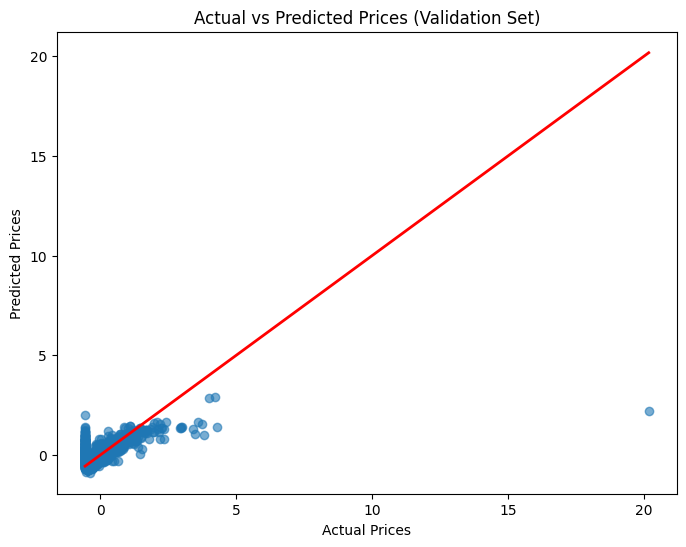

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

coefficients = model.coef_
intercept = model.intercept_

# Check if intercept is an array and handle it
if isinstance(intercept, np.ndarray):
    intercept = intercept[0]  # Extract the first intercept if it's an array

print("Linear regression equation:")
equation = f"y = {intercept:.2f} "
for i, coef in enumerate(coefficients[0]):  # Use coefficients[0] for single target variable
    equation += f"+ ({coef:.2f}) * {X_train.columns[i]} "
print(equation)

y_val_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"Validation Mean Squared Error: {mse:.2f}")
print(f"Validation R² Score: {r2:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='-', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (Validation Set)")
plt.show()


## closed form solution

weights = (X_transpose . X)^-1 . (X_transpose . y)

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]

X_transpose = X_train_with_intercept.T
X_transpose_X = np.dot(X_transpose, X_train_with_intercept)
X_transpose_X_inv = np.linalg.inv(X_transpose_X)
X_transpose_y = np.dot(X_transpose, y_train)

w = np.dot(X_transpose_X_inv, X_transpose_y)

feature_names = ['intercept'] + list(X_train.columns)

equation_terms = []
for i, coef in enumerate(w):
    equation_terms.append(f"({coef[0]:.2f}) * {feature_names[i]}")

equation = " + ".join(equation_terms)
print(f"Linear regression equation: y = {equation}")

# Add intercept to validation data and make predictions
X_val_with_intercept = np.c_[np.ones(X_val.shape[0]), X_val]
y_pred_val = np.dot(X_val_with_intercept, w)

# Calculate MSE and R² for validation data
mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f"Validation Mean Squared Error: {mse:.2f}")
print(f"Validation R² Score: {r2:.2f}")


Linear regression equation: y = (-0.61) * intercept + (0.20) * car name + (-0.05) * engine_capacity + (0.12) * cylinder + (0.21) * horse_power + (0.24) * top_speed + (-0.00) * seats + (-0.17) * brand + (-0.03) * country
Validation Mean Squared Error: 0.49
Validation R² Score: 0.33


#### compare this model with the one derived using the gradient descent method. 
Implement this part without using any external APIs or libraries for linear regression

Shape of X_train: (3784, 8)
Shape of y_train: (3784, 1)
Linear regression equation:
y = -29.99 + (-4.39) * car name + (1.14) * engine_capacity + (4.29) * cylinder + (0.13) * horse_power + (2.38) * top_speed + (7.97) * seats + (4.05) * brand + (-2.01) * country 
Validation Mean Squared Error: 26825.90
Validation R² Score: -36796.55


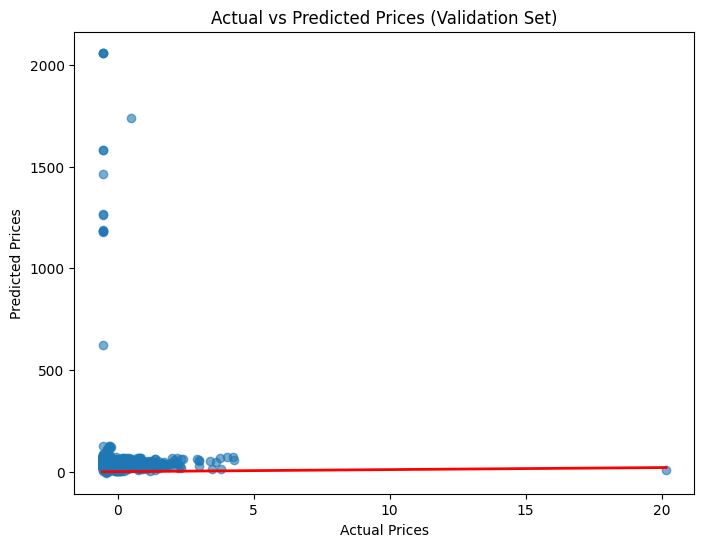

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression using Gradient Descent
def linear_regression_gd(X, y, learning_rate=0.01, epochs=1000):
    print("Shape of X_train:", X.shape)
    print("Shape of y_train:", y.shape)

    # Add intercept term (bias)
    X = np.c_[np.ones(X.shape[0]), X]  # Add a column of ones for the intercept term
    m = len(y)  # Number of samples
    n = X.shape[1]  # Number of features + 1 (for intercept term)
    
    # Initialize weights (including intercept)
    weights = np.zeros(n)  
    
    # Gradient Descent algorithm
    for epoch in range(epochs):
        predictions = np.dot(X, weights)  # Predict using the current weights
        
        # Ensure y is a 1D array to calculate errors correctly
        errors = predictions - y.flatten()  # Flatten y to make sure it is a 1D array
        
        gradient = (2/m) * np.dot(X.T, errors)  # Compute gradient of MSE
        
        # Optionally clip gradients to avoid exploding gradients
        gradient = np.clip(gradient, -1e3, 1e3)  # Clip gradients to prevent large updates
        
        weights -= learning_rate * gradient  # Update weights using the gradient
        
    return weights

# Assuming X_train and y_train are already defined as numpy arrays or pandas Series
learning_rate = 0.01
epochs = 1000
weights = linear_regression_gd(X_train, y_train, learning_rate, epochs)

# Separate intercept and coefficients
intercept = weights[0]
coefficients = weights[1:]

print("Linear regression equation:")
equation = f"y = {intercept:.2f} "
for i, coef in enumerate(coefficients):  # Use coefficients for single target variable
    equation += f"+ ({coef:.2f}) * {X_train.columns[i]} "  # Access each feature by name
print(equation)

# Predict on validation set (assuming X_val and y_val are provided)
y_val_pred = np.dot(np.c_[np.ones(X_val.shape[0]), X_val], weights)

# Calculate validation metrics
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"Validation Mean Squared Error: {mse:.2f}")
print(f"Validation R² Score: {r2:.2f}")


# Plotting Actual vs Predicted for the validation set
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='-', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (Validation Set)")
plt.show()


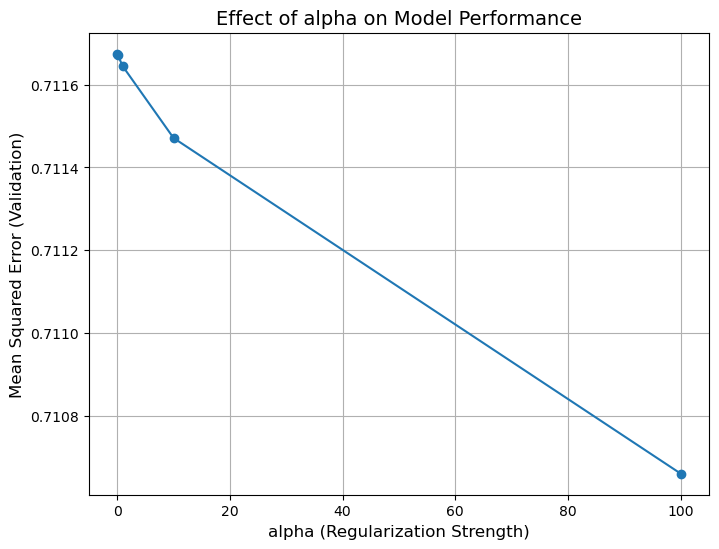

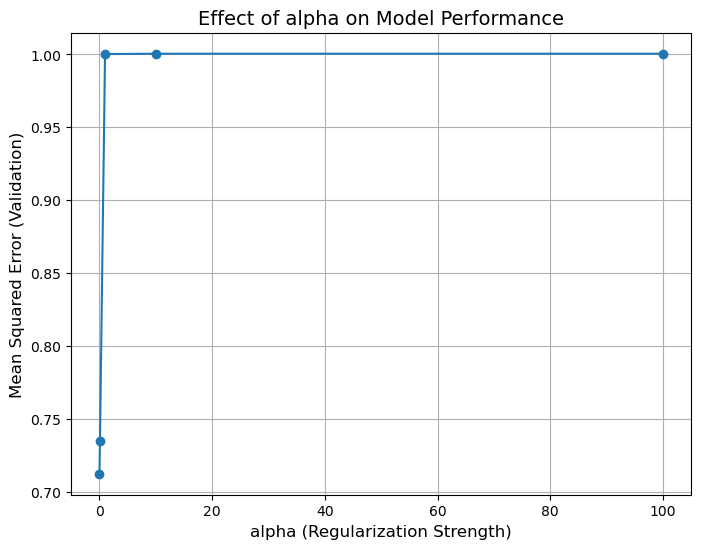

Best alpha for Ridge: 100
Best alpha for Lasso: 0.01


In [56]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

def perform_grid_search_and_plot(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
        cv=5,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    param_name = list(param_grid.keys())[0]
    
    plt.figure(figsize=(8, 6))
    plt.plot(
        results[f"param_{param_name}"],
        -results["mean_test_score"],
        marker='o'
    )
    plt.xlabel(f"{param_name} (Regularization Strength)", fontsize=12)
    plt.ylabel("Mean Squared Error (Validation)", fontsize=12)
    plt.title(f"Effect of {param_name} on Model Performance", fontsize=14)
    plt.grid(True)
    plt.show()
    
    return grid_search

# Define the parameter grids
ridge_param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}
lasso_param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Perform Grid Search and plot results for Ridge and Lasso
grid_search_ridge = perform_grid_search_and_plot(Ridge(), ridge_param_grid, X_train, y_train)
grid_search_lasso = perform_grid_search_and_plot(Lasso(), lasso_param_grid, X_train, y_train)

# Extract and print the best alpha values from the grid search results
best_alpha_ridge = grid_search_ridge.best_params_['alpha']
best_alpha_lasso = grid_search_lasso.best_params_['alpha']

print(f"Best alpha for Ridge: {best_alpha_ridge}")
print(f"Best alpha for Lasso: {best_alpha_lasso}")


Ridge Regression Equation:
y = -0.63 + (0.05) * car_name + (-0.05) * engine_capacity + (0.12) * cylinder + (0.21) * horse_power + (0.23) * top_speed + (-0.00) * seats + (-0.02) * brand + (-0.02) * country
Training Mean Squared Error: 0.69
Training R² Score: 0.31
Validation Mean Squared Error: 0.49
Validation R² Score: 0.33
--------------------------------------------------


/tmp/ipykernel_12278/140969456.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(ridge_model.intercept_)


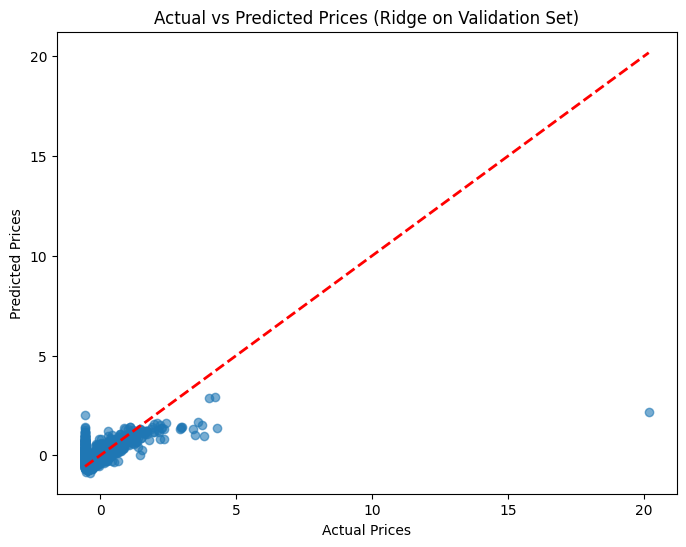

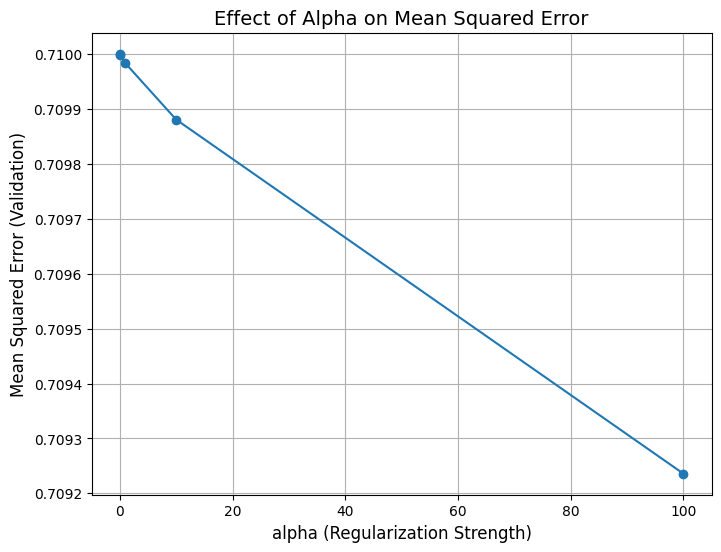

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Function to perform Grid Search and plot results
def perform_grid_search_and_plot(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    param_name = list(param_grid.keys())[0]
    
    plt.figure(figsize=(8, 6))
    plt.plot(
        results[f"param_{param_name}"],
        -results["mean_test_score"],
        marker='o'
    )
    plt.xlabel(f"{param_name} (Regularization Strength)", fontsize=12)
    plt.ylabel("Mean Squared Error (Validation)", fontsize=12)
    plt.title(f"Effect of {param_name} on Model Performance", fontsize=14)
    plt.grid(True)
    plt.show()
    
    return grid_search

# Function to perform Ridge regression grid search and plot
def perform_ridge_grid_search_and_plot(X_train, y_train, ridge_param_grid, feature_names, X_val, y_val):
    ridge = Ridge()
    grid_search_ridge = GridSearchCV(ridge, ridge_param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)    
    grid_search_ridge.fit(X_train, y_train)
    
    best_alpha_ridge = grid_search_ridge.best_params_['alpha']
    ridge_model = grid_search_ridge.best_estimator_
    
    intercept = float(ridge_model.intercept_)
    coefficients = ridge_model.coef_.flatten()
    
    # Print the Ridge regression equation
    print("Ridge Regression Equation:")
    equation = f"y = {intercept:.2f}"
    for coef, feature in zip(coefficients, feature_names):
        equation += f" + ({coef:.2f}) * {feature}"
    print(equation)

    # Predictions on training data
    y_pred_train = ridge_model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Predictions on validation data
    y_pred_val = ridge_model.predict(X_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)

    # Print performance metrics
    print(f"Training Mean Squared Error: {mse_train:.2f}")
    print(f"Training R² Score: {r2_train:.2f}")
    print(f"Validation Mean Squared Error: {mse_val:.2f}")
    print(f"Validation R² Score: {r2_val:.2f}")
    print("-" * 50)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_val, y_pred_val, alpha=0.6)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"Actual vs Predicted Prices (Ridge on Validation Set)")
    plt.show()
    
    results = pd.DataFrame(grid_search_ridge.cv_results_)
    param_name = list(ridge_param_grid.keys())[0]
    plt.figure(figsize=(8, 6))
    plt.plot(
        results[f"param_{param_name}"],
        -results["mean_test_score"],
        marker='o'
    )
    plt.xlabel(f"{param_name} (Regularization Strength)", fontsize=12)
    plt.ylabel("Mean Squared Error (Validation)", fontsize=12)
    plt.title("Effect of Alpha on Mean Squared Error", fontsize=14)
    plt.grid(True)
    plt.show()

ridge_param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

feature_names = ['car_name', 'engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'brand', 'country']

perform_ridge_grid_search_and_plot(X_train, y_train, ridge_param_grid, feature_names, X_val, y_val)


Lasso Regression Equation:
y = -0.63 + (0.02) * car_name + (-0.04) * engine_capacity + (0.12) * cylinder + (0.20) * horse_power + (0.23) * top_speed + (-0.00) * seats + (0.00) * brand + (-0.01) * country
Validation Mean Squared Error: 0.69
Validation R² Score: 0.31
--------------------------------------------------


/tmp/ipykernel_12278/3569040745.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept = float(lasso_model.intercept_)


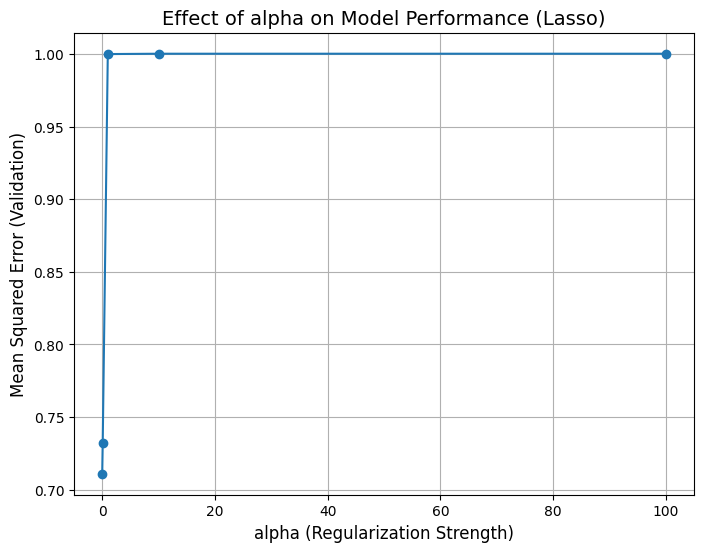

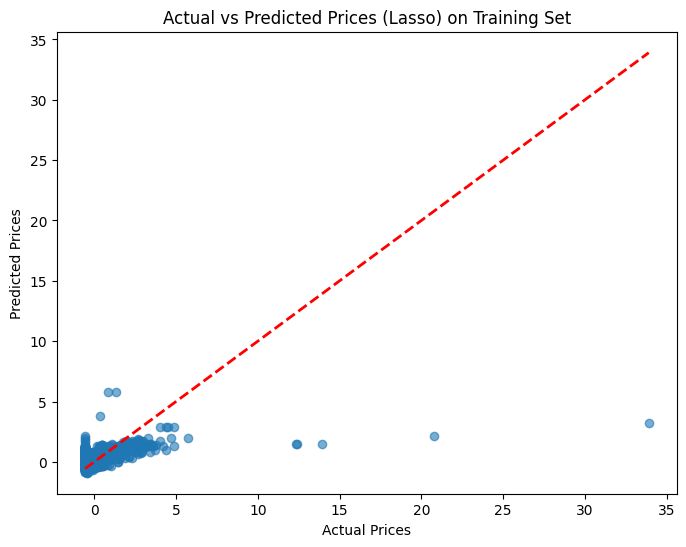

(GridSearchCV(cv=10, estimator=Lasso(),
              param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
              return_train_score=True, scoring='neg_mean_squared_error'),
 0.01)

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

def perform_lasso_grid_search_and_plot(X_train, y_train, lasso_param_grid, feature_names):
    # Define the Lasso model
    lasso = Lasso()
    
    # Perform Grid Search with cross-validation
    grid_search_lasso = GridSearchCV(lasso, lasso_param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search_lasso.fit(X_train, y_train)
    
    # Best model from Grid Search
    lasso_model = grid_search_lasso.best_estimator_
    best_alpha_lasso = grid_search_lasso.best_params_['alpha']
    
    # Get the coefficients and intercept
    intercept = float(lasso_model.intercept_)
    coefficients = lasso_model.coef_.flatten()
    
    # Print the Lasso regression equation
    print("Lasso Regression Equation:")
    equation = f"y = {intercept:.2f}"  # intercept is scalar
    for coef, feature in zip(coefficients, feature_names):
        equation += f" + ({coef:.2f}) * {feature}"
    print(equation)
    
    # Predictions and performance metrics
    y_pred = lasso_model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    
    print(f"Validation Mean Squared Error: {mse:.2f}")
    print(f"Validation R² Score: {r2:.2f}")
    print("-" * 50)

    # Plot the effect of alpha on MSE
    results = pd.DataFrame(grid_search_lasso.cv_results_)
    param_name = list(lasso_param_grid.keys())[0]
    plt.figure(figsize=(8, 6))
    plt.plot(
        results[f"param_{param_name}"],
        -results["mean_test_score"],
        marker='o'
    )
    plt.xlabel(f"{param_name} (Regularization Strength)", fontsize=12)
    plt.ylabel("Mean Squared Error (Validation)", fontsize=12)
    plt.title(f"Effect of {param_name} on Model Performance (Lasso)", fontsize=14)
    plt.grid(True)
    plt.show()

    # Plot Actual vs Predicted
    y_val_pred_lasso = lasso_model.predict(X_train)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, y_val_pred_lasso, alpha=0.6)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', linewidth=2)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"Actual vs Predicted Prices (Lasso) on Training Set")
    plt.show()

    return grid_search_lasso, best_alpha_lasso

# Define the parameter grid for Lasso
lasso_param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

# Define the feature names (adjust this list based on your actual dataset)
feature_names = ['car_name', 'engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'brand', 'country']

# Perform Grid Search and plot results for Lasso
perform_lasso_grid_search_and_plot(X_train, y_train, lasso_param_grid, feature_names)


## Non-linear Models

### Polynomial Models

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


# Polynomial Regression
degrees = [2, 5, 7, 10]

# ##with forward feature selection
# for degree in degrees:
#     print(f"Fitting degree {degree}")
    
#     poly = PolynomialFeatures(degree=degree)
#     model = LinearRegression()

#     # Run forward selection
#     selected_features, mse_history = forward_selection(X_train, X_test, y_train, y_test, model, max_features=5)
    
#     # Print the selected features and corresponding MSE history
#     print(f"Selected Features: {selected_features}")
#     for feature, mse in mse_history:
#         print(f"Feature: {feature}, MSE: {mse:.4f}")
    
#     # Train final model with selected features
#     model.fit(X_train[selected_features], y_train)
#     y_pred = model.predict(X_train[selected_features])
#     mse = mean_squared_error(y_train, y_pred)
#     print(f"Degree {degree}: MSE on training set = {mse:.4f}")
#    # model.fit(X_val[selected_features], y_val)
#     y_pred = model.predict(X_val[selected_features])
#     mse_val= mean_squared_error(y_val, y_pred)
#     print(f"Degree {degree}: MSE on validation set = {mse:.4f}")
    
#     y_pred = model.predict(X_test[selected_features])
#     final_mse = mean_squared_error(y_test, y_pred)
#     print(f"Final Model MSE on Test Set: {final_mse:.4f}")
#     print(f"Finished fitting degree {degree}")
    


#without forward feature selection

#Evaluate models with Mean Squared Error
print("Polynomial Regression Errors:")
for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_train_poly)
    mse = mean_squared_error(y_train, y_pred)
    print(f"Degree {degree}: MSE on training set = {mse:.4f}")
    model.fit(X_val_poly, y_val)
    y_pred = model.predict(X_val_poly)
    mse_val= mean_squared_error(y_val, y_pred)
    print(f"Degree {degree}: MSE on validation set = {mse:.4f}")
    model.fit(X_test_poly, y_test)
    y_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Degree {degree}: MSE on test set = {mse:.4f}")


Polynomial Regression Errors:
Degree 2: MSE on training set = 0.4593
Degree 2: MSE on validation set = 0.4593
Degree 2: MSE on test set = 0.1999
Degree 5: MSE on training set = 0.0446
Degree 5: MSE on validation set = 0.0446
Degree 5: MSE on test set = 0.0073
Degree 7: MSE on training set = 0.0509
Degree 7: MSE on validation set = 0.0509
Degree 7: MSE on test set = 0.0441
Degree 10: MSE on training set = 1.9852
Degree 10: MSE on validation set = 1.9852
Degree 10: MSE on test set = 1.4931


### Feature Selection with Forward Selection

In [48]:
# Forward Selection Function
def forward_selection(X_train, X_test, y_train, y_test, model, max_features=None):
    remaining_features = list(X_train.columns)  # All features available for selection
    selected_features = []  # Initially, no features selected
    best_mse = float('inf')  # Start with a very large MSE
    mse_history = []  # To store MSE for each feature added
    
    # Iteratively add features
    while remaining_features and (max_features is None or len(selected_features) < max_features):
        feature_mse = {}  # Dictionary to store MSE for each feature added
        for feature in remaining_features:
            # Temporarily add the feature to the selected set
            current_features = selected_features + [feature]
            
            # Train and validate the model using selected features
            model.fit(X_train[current_features], y_train)
            y_pred = model.predict(X_test[current_features])
            mse = mean_squared_error(y_test, y_pred)  # Calculate MSE on the test set
            
            feature_mse[feature] = mse  # Store the MSE for this feature
            
        # Select the feature with the minimum MSE
        best_feature = min(feature_mse, key=feature_mse.get)
        best_mse_for_feature = feature_mse[best_feature]
        
        # If the best feature improves the model, add it to selected features
        if best_mse_for_feature < best_mse:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_mse = best_mse_for_feature  # Update the best MSE
            mse_history.append((best_feature, best_mse))  # Log the feature and MSE
            
        else:
            break  # Stop if adding more features doesn't improve the model
    
    return selected_features, mse_history

### Radial Basis Function (RBF)

Model: Linear Regression
Validation Mean Squared Error (MSE): 0.49
Validation Mean Absolute Error (MAE): 0.32
Validation R² Score: 0.33
--------------------------------------------------
The best model based on the lowest MSE is: Linear Regression


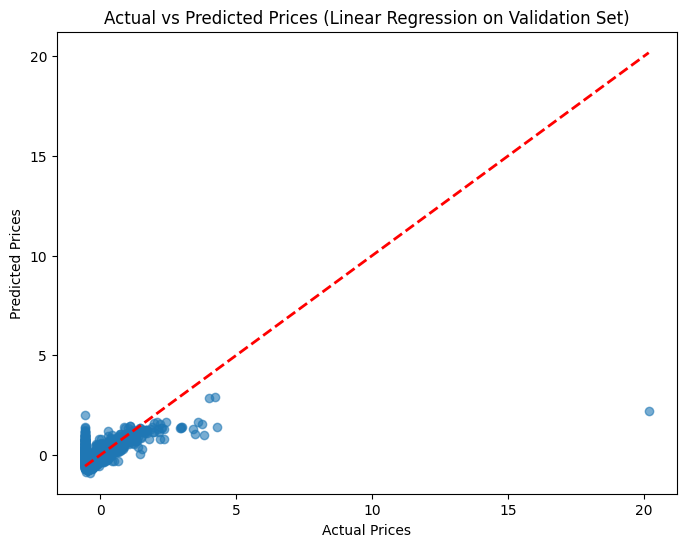

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

models = {
    'Linear Regression': LinearRegression(),
    # 'Ridge Regression': Ridge(alpha=1),
    # 'Lasso Regression': Lasso(alpha=0.1),
    # 'Polynomial Regression (Degree 2)': Pipeline([
    #     ('poly', PolynomialFeatures(degree=2)),
    #     ('model', LinearRegression())
    # ])
}

# Dictionary to store metrics for each model
model_metrics = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Store metrics in the dictionary
    model_metrics[model_name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    # Print model performance
    print(f"Model: {model_name}")
    print(f"Validation Mean Squared Error (MSE): {mse:.2f}")
    print(f"Validation Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Validation R² Score: {r2:.2f}")
    print("-" * 50)

# # Compare models based on MSE, MAE, and R²
best_model = min(model_metrics, key=lambda x: model_metrics[x]['MSE'])
# print(f"The best model based on the lowest MSE is: {best_model}")

best_model_fit = models[best_model]
y_val_pred_best_model = best_model_fit.predict(X_val)

plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred_best_model, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs Predicted Prices ({best_model} on Validation Set)")
plt.show()


In [110]:
# RBF Kernel Regression
alpha = 100      #regularization
gamma = 0.1      #kernel coefficient - low value smooths out predictions (reduce complexity)
rbf_model = KernelRidge(kernel="rbf", alpha=alpha, gamma=gamma)
rbf_model.fit(X_train, y_train)
y_rbf_pred = rbf_model.predict(X_test)

y_rbf_train_pred = rbf_model.predict(X_train)
mse_rbf = mean_squared_error(y_train, y_rbf_train_pred)
print(f"RBF Kernel: MSE on training set = {mse_rbf:.4f}")

y_rbf_val_pred = rbf_model.predict(X_val)
mse_rbf = mean_squared_error(y_val, y_rbf_val_pred)
print(f"RBF Kernel: MSE on validation set = {mse_rbf:.4f}")

y_rbf_test_pred = rbf_model.predict(X_test)
mse_rbf = mean_squared_error(y_test, y_rbf_test_pred)
print(f"RBF Kernel: MSE on testing set = {mse_rbf:.4f}")

RBF Kernel: MSE on training set = 0.8047
RBF Kernel: MSE on validation set = 0.8078
RBF Kernel: MSE on testing set = 12322249302.8753
